<i><b>Public-AI</b></i>
### week 3. Matrix Factorization
# Section 2. 베이지안 개인화 랭킹 알고리즘의 개념 및 구현

Section 1에서는 고객행동 데이터에서 아티스트와 유저의 특성을 추출해내는 Matrix Factorization의 개념을 배웠습니다. 이번에는 고객행동 데이터 중 암묵 데이터를 활용할 때 사용하는 Matrix Factorization 알고리즘 중 하나인 베이지안 개인화 랭킹 알고리즘(BPR, Bayesian Personalized Ranking)을 알아보겠습니다. 좀 더 구체적으로는 크게 알고리즘 영역과 구현 영역으로 나누어 살펴볼 예정입니다. 먼저, **[알고리즘]**에서는 암묵 데이터의 일종인 횟수 데이터를 그대로 선호도로 해석할 경우 생기는 문제점과 이를 해결하기 위해 고안된 베이지안 개인화 랭킹 알고리즘의 아이디어를 알아본 후, 의사코드를 살펴보며 보다 자세히 이해해보겠습니다. 그 다음으로 **[구현]**에서는 베이지안 개인화 랭킹 알고리즘이 구현된 파이썬의 `implicit` 라이브러리를 활용해 Last.fm 데이터로 모델 기반 협업 필터링 추천 시스템을 만들어보겠습니다. 
 
### _Objective_ 

* [**알고리즘**] : Matrix Factorization의 활용인 베이지안 개인화 랭킹 알고리즘(BPR, Bayesian Personalized Ranking)을 이용해 암묵 데이터로 추천 항목을 도출해 내는 방법을 배워봅니다.
* [**구현**] Last.fm 데이터를 BPR 의 입력데이터가 될 수 있도록 전처리한 후, BPR 알고리즘을 이용한 추천 시스템을 만들어봅니다. 


In [1]:
%matplotlib inline
import os
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.utils import get_file
np.set_printoptions(5,)

#### 데이터 가져오기

In [2]:
ROOT_URL = "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/lastfm/prep/"

# 데이터 가져오기
play_path = get_file("lastfm_play.csv", ROOT_URL+"lastfm_play.csv")
artist_path = get_file("lastfm_artist.csv",ROOT_URL+"lastfm_artist.csv")
user_path = get_file("lastfm_user.csv", ROOT_URL+"lastfm_user.csv")

play_df = pd.read_csv(play_path)
artist_df = pd.read_csv(artist_path)
user_df = pd.read_csv(user_path)

# \[ 알고리즘 \] : 베이지안 개인화 랭킹 알고리즘
---

## 1. 베이지안 개인화 랭킹(Bayesian Personalized Ranking) 알고리즘의 기본 개념
지난 Section1에서 Matrix Factorization의 개념을 배우고, 유저의 상호작용 데이터로부터 유저의 취향과 아이템의 특성을 도출해내는 임베딩에 대해 알아보았습니다. 한편, 이번 주차에 다룰 Last.fm 데이터는 지난 주차까지 다룬 Movie-lense 데이터와 다르게 상호작용 데이터 중에서도 암묵 데이터에 속한다는 것도 살펴보았습니다. <br>
이번 시간에는 횟수 데이터의 특징을 좀 더 자세히 알아본 후, 횟수 데이터의 단점을 극복하면서 Matrix Factorization을 할 수 있는 베이지안 개인화 랭킹 알고리즘에 대해 알아보겠습니다. 

### (1) 재생 횟수를 별점으로 해석하면 안되는 이유
횟수 데이터는 암묵 데이터의 대표적인 예시입니다. 횟수 데이터를 별점 데이터와 같은 명시적 데이터처럼 해석하면, 데이터를 왜곡하여 이해하는 문제가 생길 수 있습니다. 아래의 예시를 보도록 합시다.
<br>
<img src = "https://i.imgur.com/mzVQMFk.jpg" width = 600>

유저별로 위 아티스트의 음악을 평균 몇 회 감상하였다 보면 각각 아래와 같은 결과를 보여줍니다. 

In [3]:
# 마돈나, 1983년 데뷔 (그래미 7회 수상, 위키피디아 기준 277곡)
play_df.loc[play_df.artist_id==353,'plays'].mean()

299.7307707409007

In [4]:
# 비욘세, 1983년 데뷔 ( 그래미 23회 수상, 203곡)
play_df.loc[play_df.artist_id==394,'plays'].mean()

197.88797412525727

In [5]:
# 레이디 가가 (그래미 6회 수상, 141곡)
play_df.loc[play_df.artist_id==1776,'plays'].mean()

191.28937653814603

In [6]:
# 노라 존스 (그래미 5회 수상, 59곡)
play_df.loc[play_df.artist_id==709,'plays'].mean()

188.9331027903649

4명 모두 팝 가수로, 모두 가창력이나 대중성에서 큰 사랑을 받은 아티스트들입니다. 데뷔년도가 빨라 노출이 많이 된 마돈나는 노라존스에 비해 1.5배 가량 재생 횟수가 많습니다. 그렇다면 유저들이 마돈나를 노라존스보다 1.5배 더 선호한다고 볼 수 있을까요? 아티스트의 곡 수가 많을수록, 데뷔년수가 빠를수록 평균 재생 횟수는 높아지는 경향을 보이는 것은 당연한 현상일 수 있습니다. 노라존스나 레이디 가가가 마돈나보다 선호가 적다고 보는 것 보다는, 마돈나보다 노출된 기간이 짧고, 적게 음반을 발매했기에 생긴 문제로 보여집니다.

<img src = 'https://i.imgur.com/g0OJtdE.png' width=800>

이처럼 재생 횟수와 같은 횟수 데이터를 그대로 선호도로 치환하여 비교하게 되면 왜곡된 결과가 나올 수 있습니다. 평점 데이터와 다르게 횟수 데이터로는 선호의 크기를 비교하기 어렵습니다.재생 데이터를 예로 들면, 재생 횟수가 클수록 더 선호하는 음악이라고 볼 수 없는 것이죠. 대신, 재생여부를 통해 선호 아티스트와 비선호 아티스트를 구분할 수는 있을 것입니다. 베이지안 개인화 랭킹 알고리즘에서는 재생 횟수를 있는 그대로 쓰지 않고, 재생 여부 데이터를 쓰거나 활용합니다. 

### (2) 베이지안 개인화 랭킹 알고리즘의 아이디어

각 유저에 대해 아티스트는 자신의 플레이리스트에 있는 아티스트들과 플레이리스트에 없는 아티스트들로 나눌 수 있습니다.


In [7]:
# 유저별 플레이리스트 내 아티스트 구성하기
artistset_per_user = (
    play_df
    .groupby('user_id')
    ['artist_id']
    .apply(frozenset)
)

#### 유저의 플레이 리스트 확인하기 

1676번 유저의 플레이리스트를 확인해보도록 하겠습니다.

In [8]:
target_id = 1676

total_artists = set(play_df.artist_id.unique())
artists_in_plays = artistset_per_user[target_id] 
artists_not_in_plays = total_artists- artists_in_plays

재생횟수 데이터를 통해 우리가 알 수 있는 것은 아래와 같습니다. 
> 들어본 아티스트에 대한 선호가 들어보지 않은 아티스트의 선호보다 높다!

<img src = 'https://i.imgur.com/4bAcqX4.jpg' width = 600>


앞서 이야기하였듯이, 플레이리스트에 있는 아티스트 사이에서 플레이 횟수만을 가지고 서로 다른 아티스트에 대한 고객의 선호를 비교할 방법은 없습니다. 즉 우리가 가진 재생 정보로는 "마돈나를 비욘세보다 훨씬 더 선호한다" 같은 아티스트 간 고객의 선호 차이를 판단할 수 없다는 것입니다. 대신 확실히 말할 수 있는 건 "유저는 자신의 플레이리스트에 있는 아티스트를 플레이리스트에 없는 아티스트 보다 선호한다"입니다. 사람들은 자신이 선호하는 음악인의 노래를 찾아들을 것이고, 자신이 모르거나 관심없는 음악인의 노래는 웬만하면 듣지 않기 때문입니다. 이 단순한 가정이 베이지안 개인화 랭킹(Bayesian Personalized Ranking) 알고리즘의 핵심이 됩니다.  베이지안 개인화 랭킹 알고리즘은 모델을 학습시킬 때 긍정 아이템(예: 유저가 들어본 아티스트)과 부정 아이템(예: 유저가 들어보지 않은 아티스트) 사이의 랭킹을 목적함수로 두고, 그 차이가 커지는 방향으로 임베딩 변수 값을 갱신하는 것이죠. 

## 2. Bayesian Personalized Ranking의 의사 코드

긍정 아이템(예: 유저가 들어본 아티스트)과 부정 아이템(예: 유저가 들어보지 않은 아티스트) 사이의 랭킹을 목적함수로 두고, 그 차이가 커지는 방향으로 임베딩 변수 값을 갱신하는 것이 어떤 의미일까요? 베이지안 개인화 랭킹 알고리즘을 구현해보며 이해해봅시다. <br>

### (1) 데이터 준비
**먼저, 유저 취향 행렬과 아티스트 특성 행렬은 무작위값으로 초기화하여 준비합니다.**<br>
베이지안 개인화 랭킹 알고리즘의 개념을 알기 위한 의사코드이므로, 데이터는 제일 정보가 많은 유저와 아티스트를 추리기 위해 유저와 아티스트 각각 상위 100명을 가져와 샘플 데이터를 구성하겠습니다.
<br>
<img src = 'https://i.imgur.com/74FpgBH.png'>
<br>

In [10]:
# BPR simple code를 위한 데이터셋 : 
#   상위 100명의 유저 / 상위 100명의 아티스트에 대한 play_df
top_user = (
    play_df
    .user_id
    .value_counts()
    .sort_values(ascending=False)
    [:100].index)

top_artist = (
    play_df
    .artist_id
    .value_counts()
    .sort_values(ascending=False)
    [:100].index)

top_df = play_df[(play_df.user_id.isin(top_user)) & 
                 (play_df.artist_id.isin(top_artist))]

top_df.head()

#### BPR 알고리즘의 4가지 파라미터 

* `num_factors` : 추출할 임베딩 변수의 갯수
* `lr`: 학습률
* `reg`: 정규화
* `num_epoch`: 총 학습 횟수

In [1]:
# BPR Simple Code
num_factors = 10 
lr = 0.1 
reg = 0.01 
num_epoch = 10 

베이지안 개인화 랭킹 알고리즘을 통한 임베딩의 최종 결과가 될 유저 취향 행렬(`user_embeddings`)과 아티스트 특성 행렬(`artist_embeddings`)은 각각 유저 수(`len(user_df)`) 또는 아티스트의 수(`len(artist_df)`)만큼의 행과 임베딩 변수의 갯수(`num_factors`)만큼의 열을 가지도록 구성합니다.

#### 유저 임베딩 행렬, 아티스트 임베딩 행렬 초기화하기

In [13]:
user_embeddings = np.random.normal(size=(len(user_df), num_factors))
artist_embeddings = np.random.normal(size=(len(artist_df), num_factors))
bias_embeddings = np.ones((len(artist_df),))

print('유저 취향 행렬의 shape', user_embeddings.shape)
print('아티스트 특성 행렬의 shape', artist_embeddings.shape) 

### (2) 전체 순회 구문

이제 샘플로 뽑아둔 `top_df`의 각 행을 순차적으로 돌며 임베딩 값을 계산해야 합니다. 또한 전체 데이터에 대해 설정해둔 총 학습 횟수(`num_epoch`)만큼 학습을 반복할 예정입니다.따라서 for 반복문이 아래와 같이 이중으로 중첩될 것입니다. 

```python
for epoch in tqdm(range(1,num_epoch+1)):
    # 각 회차의 학습 실행(num_epoch 만큼 반복) 
    history =[]
    for c, (idx, row) in enumerate(top_df.iterrows()):
        # 각 행에 대한 n회차의 학습
        # - 유저가 들어본 아티스트와 들어보지 않은 아티스트를 쌍으로 뽑기 
        # - 들어본 아티스트와 유저의 유사도 구하기(=유사도A)
        # - 들어보지 않은 아티스트와 유저의 유사도 구하기(=유사도B)
        # - 유사도A와 유사도B의 차이가 커지는 방향으로 임베딩 행렬의 값 업데이트하기
```

### (3) 각 행에 대한 n회차의 학습

두 번째 for 문 안에서 실행되는 "top_df의 각 행에 대한 n회차의 학습"부분의 코드를 단계별로 알아봅시다.
<img src = 'https://i.imgur.com/1fYCDmg.png'><br>

먼저, 유저가 들어본 아티스트와 들어보지 않은 아티스트를 쌍으로 뽑아야 합니다. `top_df`의 각 행은 유저 한 명이 특정 아티스트의 음악을 몇 번 들었는지에 대한 데이터입니다. 해당 유저의 임베딩 벡터(`user`)를 가져오고, 해당 유저가 들은 아티스트(`pos_artist`)에 대한 임베딩 벡터을 가져옵니다. 그 다음에, 유저가 듣지 않은 아티스트 중에서 랜덤으로 한 아티스트를 뽑아 그 아티스트의 임베딩 벡터(`neg_artist`)를 가져옵니다. 이렇게 유저가 들어본 아티스트와 들어보지 않은 아티스트를 쌍으로 뽑았습니다.

```python
 # 유저의 임베딩과 유저가 들은 아티스트에 대한 임베딩 가져오기
user = user_embeddings[row.user_id]
pos_artist = artist_embeddings[row.artist_id]
pos_bias = bias_embeddings[row.artist_id]

# 유저가 듣지 않은 아티스트 중에서 랜덤으로 하나 가져오기
artists_not_in_plays = total_artists - artistset_per_user[row.user_id]
neg_artist_id = random.choice(list(artists_not_in_plays))
neg_artist = artist_embeddings[neg_artist_id]
neg_bias = bias_embeddings[neg_artist_id]
```

<br>

<img src = 'https://i.imgur.com/2gjFLAD.png'><br>

그 다음에는 들어본 아티스트와 유저의 유사도를 구하고, 들어보지 않은 아티스트와 유저의 유사도를 구해야 합니다. 유사도는 유저 임베딩 벡터와 아티스트 임베딩 벡터를 내적 연산(dot product)하여 계산할 수 있습니다. <br>

```python
# 들어본 아티스트의 임베딩과 유저 임베딩, 
# 듣지 않은 아티스트의 임베딩과 유저 임베딩을 각각 내적 연산(dot product) 하여
# 스코어를 계산
pos_score = np.dot(user, pos_artist) + pos_bias
neg_score = np.dot(user, neg_artist) + neg_bias
```


<br>

<img src = 'https://i.imgur.com/SdPSDCp.png'><br>

끝으로, 두 값의 차이가 커지는 방향으로 임베딩 값을 수정해야 합니다. 이때 경사하강법(Gradient Descent)을 이용해 두 스코어의 차이가 커지는 방향으로 임베딩을 수정합니다. 경사하강법의 자세한 내용은 다음 주차에 딥러닝 기초를 배우며 자세히 설명하겠습니다.


```python
# 두 스코어의 차이를 구함
diff_score = pos_score - neg_score    

# 두 스코어의 차이가 커지는 방향으로 임베딩을 수정 (Gradient Descent 방법)
z = 1.0 / (1.0 + np.exp(-diff_score))

user_embeddings[row.user_id] -= lr * ((z-1) * (pos_artist - neg_artist) - reg * user)
artist_embeddings[row.artist_id] -= lr * ((z-1) * user - reg * pos_artist)
artist_embeddings[neg_artist_id] -= lr * (-(z-1) * user - reg * neg_artist)

bias_embeddings[row.artist_id] -= lr * ((z-1) - reg * pos_bias)
bias_embeddings[neg_artist_id] -= lr * (-(z-1) - reg * neg_bias) 

history.append(z >= .5)
```

In [15]:
# BPR simple code를 위한 데이터셋 : 
#   상위 100명의 유저 / 상위 100명의 아티스트에 대한 play_df
top_user = (
    play_df
    .user_id
    .value_counts()
    .sort_values(ascending=False)
    [:100].index)

top_artist = (
    play_df
    .artist_id
    .value_counts()
    .sort_values(ascending=False)
    [:100].index)

top_df = play_df[(play_df.user_id.isin(top_user)) & 
                 (play_df.artist_id.isin(top_artist))]

# BPR Simple Code
num_factors = 10
lr = 0.1 # 학습률
reg = 0.01 # 정규화
num_epoch = 10 # 총 학습 수

# 초기화
user_embeddings = np.random.normal(size=(len(user_df), num_factors))
artist_embeddings = np.random.normal(size=(len(artist_df), num_factors))
bias_embeddings = np.ones((len(artist_df),))


for epoch in tqdm(range(1,num_epoch+1)):
    history = []
    for c, (idx, row) in enumerate(top_df.iterrows()):
        # 각 행에 대한 n회차의 학습
         
        # - 유저가 들어본 아티스트와 들어보지 않은 아티스트를 쌍으로 뽑기         
        
        # - 들어본 아티스트와 유저의 유사도 구하기(=유사도A)
        
        # - 들어보지 않은 아티스트와 유저의 유사도 구하기(=유사도B)
        
        # - 유사도A와 유사도B의 차이가 커지는 방향으로 임베딩 행렬의 값 업데이트하기
        
        history.append(z >= .5)
    accuracy = sum(history)/len(history)
    print("{}회차 정확도 : {:2.3%}".format(epoch, accuracy))

 10%|█         | 1/10 [00:03<00:35,  3.90s/it]

1회차 정확도 : 53.325%


 20%|██        | 2/10 [00:07<00:29,  3.74s/it]

2회차 정확도 : 68.198%


 30%|███       | 3/10 [00:10<00:25,  3.62s/it]

3회차 정확도 : 78.597%


 40%|████      | 4/10 [00:14<00:21,  3.64s/it]

4회차 정확도 : 85.006%


 50%|█████     | 5/10 [00:18<00:19,  3.85s/it]

5회차 정확도 : 91.415%


 60%|██████    | 6/10 [00:22<00:15,  3.79s/it]

6회차 정확도 : 92.987%
7회차 정확도 : 96.252%


 80%|████████  | 8/10 [00:28<00:06,  3.49s/it]

8회차 정확도 : 96.856%


 90%|█████████ | 9/10 [00:31<00:03,  3.39s/it]

9회차 정확도 : 97.461%


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]

10회차 정확도 : 98.065%


파이썬의 코드는 메모리나 최적화 측면에서 C보다는 느리게 동작합니다. 위의 코드를 C++로 최적화한 `implicit`이라는 파이썬 패키지를 이용해보도록 하겠습니다.

# \[ 구현 \]
---
Last.fm 데이터를 이용해 모델기반 협업 필터링을 구현해보겠습니다. 보다 구체적으로는 다음 5단계에 걸쳐 구현해볼 것입니다. 첫번째로 전체 데이터에서 K-Core Sampling으로 대상 데이터 걸러내겠습니다. 그 다음 단계에서는 걸러낸 데이터를 유저-아이템 행렬로 변환하면 생기는 희소 행렬의 메모리 문제를 알아보고, 이를 해결하기 위해 희소행렬을 압축하는 작업을 하겠습니다. 세번째 단계에서는 `implicit` 패키지를 이용해 베이지안 개인화 랭킹 알고리즘으로 선호 데이터로부터 유저와 아티스트의 특성을 추출해내는 임베딩 학습, 즉 matrix factoriztion을 하겠습니다. 네번째 단계에서는 학습된 임베딩을 확인하고, 끝으로 다섯번째 단계에서는 이를 활용해 아티스트를 추천해보겠습니다.

## 1. K-Core Sampling으로 대상 데이터 걸러내기

모든 유저의 재생 횟수 데이터를 이용해서 추천 시스템을 만든다고 좋은 것은 아닙니다. 2명에서 3명의 아티스트만 고집해서 듣는 유저와, 2명에서 3명의 유저만이 듣는 아티스트의 재생 정보는 Matrix Factorization을 통해 올바르게 임베딩을 하기 어렵습니다. 이렇게 적은 정보를 가진 유저와 아티스트들은 특정 값으로 편향될 우려가 있기 때문에, 모델의 학습이 일반화되지 못할 우려가 있습니다. 따라서 적절한 기준을 가지고 편향을 발생시킬 우려가 있는 샘플은 제거해야 합니다. 

이때 사용할 수 있는 샘플링 방법 중 하나가 K-core Pruning 기법입니다. K-core Pruning은 K개 이상의 데이터가 보장된 샘플들만 추출하는 샘플링 기법입니다. 예를 들어 k=2로 설정한다면, 최소 2개의 데이터가 보장된 노란색과 빨간색 점만 남기고, 파란색 점은 제거(pruning)되는 것이죠. <br>

<img src = 'http://3.bp.blogspot.com/-TIjz3nstWD0/ToGwUGivEjI/AAAAAAAAsWw/etkwklnPNw4/w1200-h630-p-k-no-nu/k-cores.png'>
<br>

Last.fm 데이터에 적용한다면, K명 이상의 유저가 들은 아티스트만 남기고, K명 이상의 아티스트의 음악을 들은 유저만 남기는 것이죠.<br>

<img src = 'https://i.imgur.com/W7Cwsyc.jpg'>
<br>

위 이미지처럼 그래프 형식으로 데이터를 변환하여 그래프 알고리즘으로 데이터를 제거할 수도 있지만, 이번 시간에는 간단하게 Dataframe을 반복적으로 필터링하여 제거하는 방식으로 진행하도록 하겠습니다.

In [16]:
# 재생 횟수가 하위 10퍼센트보다 많은 것들만 선호하여 재생하였다고 판단
like_df = play_df[play_df.plays>play_df.plays.quantile(0.1)]

threshold = 5

count = 0
while True:
    prev_total = len(like_df)
    print("{}회차 데이터 수 : {:,}개".format(count, prev_total))
    
    total_user_per_artist = (
        like_df
        .groupby('artist_id')['user_id']
        .count())
    over_artist_ids = total_user_per_artist[
        total_user_per_artist>threshold].index
    
    total_artist_per_user = (
        like_df
        .groupby('user_id')['artist_id']
        .count())
    over_user_ids = total_artist_per_user[
        total_artist_per_user>threshold].index
    
    like_df = like_df[
        (like_df.user_id.isin(over_user_ids))
        &(like_df.artist_id.isin(over_artist_ids))]

    if prev_total == len(like_df):
        print("종료")
        break
    count += 1

0회차 데이터 수 : 15,494,436개
1회차 데이터 수 : 15,306,742개
2회차 데이터 수 : 15,305,394개
3회차 데이터 수 : 15,305,294개
종료


K개(이 경우 5명)의 데이터가 보장되지 못하는 샘플들을 추려내는 과정을 반복적으로 순회하며 데이터를 걸러냅니다. 이 과정은 아래 조건을 만족하면 반복을 멈춥니다. 

> 이번 회차에서 걸러내고 남은 `like_df`의 크기(`len(like_df)`)가 이전 회차에서 걸러내고 남은 `like_df`의 크기(`prev_total`)보다 같을 때

총 3회차에서 목표하는 데이터 수를 달성하였습니다. 즉, 4회차에서 3회차에 비해 더 이상 데이터가 줄어들지 않는 것을 알 수 있습니다. 이렇게 K-core pruning을 통해 데이터의 수를 줄이고 난 후 남은 유저와 아티스트의 수는 아래와 같습니다.<br>

In [17]:
num_like_user = len(like_df.user_id.unique())
num_total_user = len(play_df.user_id.unique())
ratio_user = num_like_user / num_total_user

print("user의 수 : {:,}명/{:,}명  ({:.3%})".format(num_like_user, num_total_user, ratio_user))

num_like_item = len(like_df.artist_id.unique())
num_total_item = len(play_df.artist_id.unique())
ratio_item = num_like_item / num_total_item

print("아티스트의 수 : {:,}명/{:,}명  ({:.3%})".format(num_like_item, num_total_item, ratio_item))

user의 수 : 342,852명/358,856명  (95.540%)
아티스트의 수 : 73,556명/160,110명  (45.941%)


여기에 포함되지 못한 유저와 아티스트는 추천 시스템을 만들기 위해 Matrix Factorization 작업을 하는 단계에서 제외됩니다. 이처럼 초기 정보가 부족해서 추천을 하지 못하는 유저와 아티스트가 발생하는데, 이 문제를 "Cold Start 문제"라 부릅니다. 이런 문제를 완화하기 위해, 아티스트의 태그 정보를 이용하거나 유저의 관심 분야를 조사하여 따로 추천할 아이템을 선정하는 등의 다양한 보완 방법이 활용되고 있습니다.<br>

## 2. 유저-아이템 행렬을 희소 행렬로 변환하기 
### (1) 유저-아이템 행렬의 메모리 줄이는 방법
지난 시간에 고객의 선호 정보를 유저-아이템 행렬(User-Item Matrix)로 변환하여 표현할 수 있다고 배웠습니다. 1주차와 2주차에선 영화 평점 데이터를 사용하였는데, 이번 주차에 사용할 횟수 데이터 역시 유저-아이템 행렬로 변환할 수 있습니다. 이때 User의 수와 Item의 수에 비해, 선호 정보의 수는 매우 적기 때문에, 대부분 0으로 가득찬 행렬로 표현됩니다. 이러한 행렬을 그대로 기존의 `np.ndarray`로 표현하게 되면 너무 많은 메모리를 사용하게 됩니다.<br>

예를 들어 아래와 같은 유저-아이템 행렬이 있다고 합시다. <br>

In [18]:
dense_matrix = np.array([
    [2,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,4,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,3,4,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [1,2,0,0,0,0,0,0,0,0,0,0,0,0,0]])

실제 유용한 선호 데이터는 첫 번째 행에는 2, 두 번째 행에는 4, 세 번째 행에는 [3,4], 네 번째 행에는 1, 다섯번째 행에는 [1,2] 등 총 7개 밖에 없습니다. `dense_matrix`는 (5,15)의 형태를 가진 행렬로, 75개의 값 중 7개를 제외한 나머지 0으로 채워진 부분은 선호 정보가 없는 부분임에도 메모리를 차지하게 됩니다. `scipy`라이브러리에서는 이러한 행렬을 다루기 위한 API를 제공합니다. `scipy.sparse`의 `csr_matrix`는 데이터와 인덱스를 따로 저장하는 매트릭스 형태로, 위와 같이 대부분의 값이 0인 행렬에서 메모리의 낭비를 줄일 수 있습니다.

In [19]:
from scipy.sparse import csr_matrix

# 데이터와 인덱스를 따로 저장하는 매트릭스 형태 
# 대부분의 값이 0인 행렬에서는 메모리의 낭비를 줄일 수 있음
val = [2,4,3,4,1,1,2] # 선호 정보
row = [0,1,2,2,3,4,4] # 각 선호 정보의 행 인덱스
col = [0,2,5,6,14,0,1] # 각 선호 정보의 열 인덱스

# (값, (행, 열))의 튜플 목록으로 저장. 
sparse_matrix = csr_matrix((val, (row, col)))
sparse_matrix

<5x15 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

`sparse_matrix`를 전과 같이 데이터가 없는 부분을 0으로 채운 밀집행렬 꼴로 바꾸고 싶다면 아래와 같이 적용해주면 됩니다.

In [20]:
sparse_matrix.todense()

matrix([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

밀집행렬 형태일 때와 희소 행렬 형태일 때의 메모리 크기를 비교하면 아래와 같습니다. <br>

In [21]:
print("밀집행렬일때의 메모리 크기 : {} bytes".format(dense_matrix.data.nbytes))
print("희소행렬일때의 메모리 크기 : {} bytes".format(sparse_matrix.data.nbytes))

밀집행렬일때의 메모리 크기 : 600 bytes
희소행렬일때의 메모리 크기 : 56 bytes


### (2) `like_df`를 희소행렬로 변환하기

재생 횟수 데이터(`like_df`)를 압축된 희소행렬로 바꾸기 위해서는 우선 `artist_id`와 `user_id`를 각각 행 번호(index)와 열 번호(index)로 바꾸어야 합니다. `artist_id`와 `user_id`를 0부터 시작하여 새롭게 인덱스를 지정해 주도록 하겠습니다. 이를 pandas에서 `pd.Categorical`을 이용하면 손쉽게 할 수 있습니다.

In [22]:
like_df['user_id'] = pd.Categorical(like_df['user_id'])
like_df['artist_id'] = pd.Categorical(like_df['artist_id'])

위를 수행하면 `user_id`와 `artist_id`는 아래처럼 0부터 순서대로 새로운 인덱스를 가지게 됩니다.<br>

In [23]:
like_df.user_id.cat.categories

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 9,     10,
            ...
            359337, 359338, 359339, 359340, 359341, 359342, 359343, 359344,
            359345, 359346],
           dtype='int64', length=342852)

| artist_index | 0| 1 | 2 | $\cdots$ | 73554 | 73555 |
| ------- |---|---|---|---|----|----|
| artist_id | 0 | 1 | 2 | $\cdots$ | 148796 | 153543 |



In [24]:
like_df.artist_id.cat.categories

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            143188, 143435, 143877, 144870, 145531, 145603, 146361, 148449,
            148796, 153543],
           dtype='int64', length=73556)


| user_index | 0| 1 | 2 | $\cdots$ | 342850 |342851 |
| ------- |---|---|---|---|----|----|
| user_id | 0 | 1 | 2 | $\cdots$ | 359345 |359346 |



In [25]:
# index값으로 가져오기
user_index = like_df['user_id'].cat.codes.values
artist_index = like_df['artist_id'].cat.codes.values

이제 `like_df`의 선호도 데이터(재생 횟수)를 압축된 희소행렬로 표현하기 위해 선호도 값과 각 값의 행 인덱스와 열 인덱스를 아래와 같이 저장하고, `csr_matrix`을 이용해 희소 행렬로 변환하겠습니다.

In [26]:
val = like_df.plays.values.astype(np.float32)
row = artist_index.copy()
col = user_index.copy()

inputs = csr_matrix((val, (row, col)))
inputs

<73556x342852 sparse matrix of type '<class 'numpy.float32'>'
	with 15304943 stored elements in Compressed Sparse Row format>

In [27]:
dense_size = 73556 * 342852 / 2**30 * 8 
print(f"밀집 행렬로 나타내었을 때 필요한 메모리 크기 : {dense_size:.2f} GB")

sparse_size = inputs.data.nbytes / 2**30 * 8
print(f"희소 행렬로 나타내었을 때 필요한 메모리 크기 : {sparse_size:.2f} GB")

밀집 행렬로 나타내었을 때 필요한 메모리 크기 : 187.89 GB
희소 행렬로 나타내었을 때 필요한 메모리 크기 : 0.46 GB


이렇게 메모리 크기가 줄어든 행렬을 이용해 `implicit` 라이브러리에서 C로 최적화된 코드를 통해 Matrix Factorization를 수행해봅시다.

## 3. `implicit`으로 모델 학습시키기

`implicit`은 파이썬으로 암묵 데이터셋을 이용한 협업 필터링 추천 시스템을 만들 때 사용하는 패키지로, 앞서 의사코드로 작성한 코드보다 최적화가 되어있기 때문에 빠릅니다. <br>
이 패키지로 할 수 있는 Matrix Factorization은 위에서 설명한 베이지안 개인화 랭킹 외에도 ALS(Alternating Least Squares), Logistic Matrix Factorization 등 다양한 방법이 존재하는데, 우리는 베이지안 개인화 랭킹을 이용하도록 하겠습니다.

````shell
# implicit을 설치해주시길 바랍니다.
pip install implicit
conda install -c conda-forge implicit # anaconda 환경에서는 아래의 명령어로 쉽게 설치가 가능합니다.
````

`implicit.bpr`에서 `BayesianPersonalizedRanking`을 가져옵니다.

In [ ]:
from implicit.bpr import BayesianPersonalizedRanking

# 60개의 Factor로 나누어주세요
model = BayesianPersonalizedRanking(factors=60)

# 컴퓨터 사양에 따라 적게는 5분에서 많게는 1시간 가량 소요
model.fit(inputs)

위의 모델을 학습하는데 시간이 소요되므로, 이미 학습된 모델을 가져와 이용하도록 하겠습니다.

In [30]:
import pickle

model_path = get_file("lastfm_model.pkl", ROOT_URL+"lastfm_model.pkl")

with open(model_path, 'rb') as f:
    model = pickle.load(f)

101605376/101604179 [==============================] - 9s 0us/step


## 4. 학습된 임베딩 행렬 가져오기
학습된 임베딩 행렬은 `model.user_factors`와 `model.item_factors`에 저장되어 있습니다.

In [31]:
user_embeddings = model.user_factors
item_embeddings = model.item_factors

좀 더 가독성을 높이기 위해서 각 임베딩 행 별로 아티스트의 이름과 유저의 id를 매칭시켜 데이터프레임(dataframe)을 구성하도록 하겠습니다.

In [32]:
artist_id2name = {k: v for k, v in artist_df.artist_name.items()}
artist_names = [artist_id2name[artist_id] for artist_id 
                in like_df.artist_id.cat.categories]

artist_embedding_df = pd.DataFrame(item_embeddings,
                                   index=artist_names)

artist_embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
betty blowtorch,-0.144451,0.076572,0.281116,-0.472154,-0.451487,0.257536,0.446137,0.102796,-0.157507,-0.100101,...,0.362161,0.233857,-0.061627,-0.745317,-0.265155,0.241800,0.135403,-0.036732,-0.374584,-0.120217
die Ärzte,-0.697556,-0.035565,-0.374686,-0.264586,-0.083757,0.286023,0.384022,-0.003874,-0.296005,0.171933,...,0.262452,-0.226928,0.329184,0.678527,0.177421,0.116744,-0.022809,0.342500,-0.221481,-0.025556
melissa etheridge,0.077769,0.121082,-0.249565,-0.090846,-0.348378,0.314046,-0.149708,0.063845,0.261751,0.009993,...,0.475654,0.278731,-0.370669,-0.316834,-0.047094,0.420314,-0.511336,-0.077010,-0.095010,-0.155107
elvenking,-0.268564,-0.437870,0.008659,-0.348533,-0.148404,0.028136,0.367035,0.186630,-0.249693,0.037502,...,0.524033,-0.020302,0.719446,0.450065,-0.112946,-0.469274,-0.154084,-0.520436,0.160595,-0.285434
juliette & the licks,-0.517480,0.363873,0.179052,-0.301224,0.041626,-0.008498,0.685440,-0.023404,0.158394,0.036456,...,-0.015704,0.179171,0.111696,-0.434927,-0.193975,0.452577,-0.099302,0.016116,-0.352386,0.407580


예를 들면 가수 리한나의 임베딩 결과는 아래와 같습니다.

In [33]:
print(artist_embedding_df.loc["rihanna"].values)

[-0.05405  0.06947 -0.05277  0.0343  -0.22404  0.21258 -0.37661  0.02953
  0.04581 -0.20766  0.22363 -0.38963 -0.02352  0.04009 -0.07061 -0.50003
  0.27916  0.5488  -0.08009  0.02447  0.0952   0.26589  0.34597 -0.15336
  0.20071 -0.72577 -0.18223 -0.48076 -0.21132 -0.12993 -0.47549 -0.09235
 -0.07299  0.86249  0.28659 -0.15728  0.23581 -0.14822 -0.02625  0.00163
 -0.46442  0.38805  0.40596 -0.07404 -0.2785   0.16548  0.1591  -0.13085
 -0.20338  0.2316  -0.38274 -0.29622  0.41512 -0.00642  0.06463  0.10549
 -0.2704  -0.10387  0.0876   0.28184  0.08584]


In [34]:
user_names = [user_id for user_id 
              in like_df.user_id.cat.categories]

user_embedding_df = pd.DataFrame(user_embeddings,
                                 index=user_names)
user_embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-0.619291,-0.298394,0.214925,-0.490792,-0.327859,0.292962,0.496195,-0.038399,0.027289,0.193604,...,0.280015,0.004481,-0.145758,-0.151483,-0.138469,0.396809,-0.169546,-0.144158,-0.268921,1.0
1,-0.207102,-0.309643,0.133795,0.086895,0.407146,0.015037,-0.585557,-0.101422,-0.348943,-0.048778,...,-0.757391,0.077940,-0.101488,0.025202,0.065900,0.300783,0.417340,-0.271042,-0.466830,1.0
2,0.062470,0.239077,-0.542327,0.010113,-0.345730,0.077013,-0.433886,-0.005150,-0.445595,-0.359336,...,0.347684,-0.144460,0.094007,-0.716361,-0.294557,0.573322,-0.012453,-0.445074,-0.054605,1.0
3,-0.235317,-0.413001,-0.193653,-0.543128,-0.592471,0.001346,0.181930,0.081777,-0.114576,-0.020358,...,0.398491,-0.109125,0.470624,-0.088086,-0.196226,-0.074758,-0.108785,-0.359343,0.155990,1.0
4,0.212228,0.228739,-0.353603,0.442860,0.075671,0.102480,-0.325401,-0.282224,-0.397547,-0.290963,...,-0.423411,-0.217152,-0.337311,-0.547562,-0.094016,0.091417,-0.018694,0.244212,-0.122436,1.0


임베딩에는 bias Factor가 각각 하나 더 붙어서, 임베딩의 크기는 `factor + 1`가 됩니다. bias factor는 각각 마지막 행에 붙습니다.

## 5. 학습된 임베딩 행렬로 추천 시스템 만들기

앞서 계산한 `artist_embedding_df`와 `user_embedding_df`는 추천 시스템에서 핵심적인 정보가 됩니다. <br>
이 정보는

1. 즐겨듣는 아티스트와 유사한 아티스트 추천하기
2. 유저군 분석하기
3. 유저의 취향과 비슷한 특성을 가진 아티스트 추천하기

등에 다양하게 이용할 수 있습니다. <br>

### (1) 즐겨듣는 아티스트와 유사한 아티스트 추천하기

내적 연산(dot product)를 통해 두 벡터의 유사도를 계산할 수 있다고 배웠습니다. 각 아티스트의 임베딩을 다른 아티스트의 임베딩과 내적 연산하여 아티스트 사이의 유사도를 구하면, 각 아티스트와 가장 높은 유사도를 가진 아티스트를 찾을 수 있습니다.

어떤 유저가 가장 많이 듣는 음악이 제이슨 므라즈의 음악이라고 해봅시다. 제이슨 므라즈와 가장 유사한 아티스트를 찾아 그의 음악을 추천하면, 아무나 뽑아 추천하는 것보다 유저의 사용자 경험이 좋아질 것입니다. `artist_embedding_df`에서 제이슨 므라즈의 임베딩 벡터를 가져와 `target_embedding`에 저장한 후, 다른 아티스트 임베딩과 내적 연산을 진행하면 제이슨 므라즈와 다른 아티스트 사이의 유사도를 각각 구할 수 있습니다. 그 결과를 이용해 제이슨 므라즈와 가장 유사도가 높게 나온 10명의 아티스트를 추려보겠습니다.

In [36]:
target_embedding = artist_embedding_df.loc['jason mraz']

(
    artist_embedding_df
    .dot(target_embedding)
    .sort_values(ascending=False)
    .iloc[:10]
)

jason mraz        4.207849
matt wertz        4.090848
mozella           4.046325
josh kelley       4.024017
matt white        4.022907
justin nozuka     3.986100
jason reeves      3.977895
stephen speaks    3.963044
gavin degraw      3.909294
ernie halter      3.908013
dtype: float32

브리트니 스피어스와 가장 비슷한 가수들은 아래와 같이 나타나게 됩니다.

In [37]:
target_embedding = artist_embedding_df.loc['britney spears']

(
    artist_embedding_df
    .dot(target_embedding)
    .sort_values(ascending=False)
    .iloc[:10]
)

britney spears      5.282470
paris hilton        4.914952
nadia oh            4.717860
lady gaga           4.708811
spice girls         4.693348
lindsay lohan       4.663288
tila tequila        4.538540
girlicious          4.503564
victoria beckham    4.495034
rihanna             4.484206
dtype: float32

에미넴과 비슷한 가수들은 아래와 같이 나타나게 됩니다.

In [38]:
target_embedding = artist_embedding_df.loc['eminem']

(
    artist_embedding_df
    .dot(target_embedding)
    .sort_values(ascending=False)
    .iloc[:10]
)

eminem             5.065014
d12                4.535865
50 cent            4.456193
dmx                4.354797
ying yang twins    4.242460
ludacris           4.153105
xzibit             4.131972
obie trice         4.124792
chamillionaire     4.064129
2pac               4.062963
dtype: float32

## (2) 유저군 분석하기

유저 취향 임베딩 행렬과 유저의 정보 데이터(연령, 성별 등)를 같이 활용하면, 유저의 특성별(연령대별, 세대별, 성별 등) 음악적 취향이 어떻게 차이가 나는지를 시각화하여 분석할 수 있습니다.<br>

유저 임베딩 데이터를 이용해 유저군을 분석해봅시다. 임베딩 행렬을 시각화하기 위해서 임베딩 행렬의 차원을 2차원으로 줄이는 작업이 필요합니다. 데이터가 2차원을 넘어가면 시각화가 쉽지 않기 때문입니다. 데이터의 차원을 줄이기 위한 방법 중 하나가 바로 주성분 분석(PCA, Principal Component Analysis)입니다. 주성분 분석은 원본 데이터의 가장 정보를 덜 손상시키는 방향으로 주성분 N개를 추출하여 N개의 차원으로 데이터를 줄여줍니다. PCA는 파이썬의 대표적인 머신러닝 패키지 중 하나인 `scikit-learn`에서 제공됩니다.

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(user_embedding_df)

우선 성별에 따른 차이를 보도록 하겠습니다.

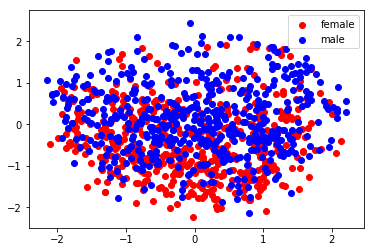

In [41]:
id2index = {v: k for k, v 
            in enumerate(like_df.user_id.cat.categories)}

# 
f_sampled = (
    user_df[user_df.gender=='f']
    .user_id.map(id2index)
    .dropna().astype(int).sample(500))

plt.scatter(x=pca_matrix[f_sampled.values, 0],
            y=pca_matrix[f_sampled.values, 1],
            c='red',
            label='female')

m_sampled = (
    user_df[user_df.gender=='m']
    .user_id.map(id2index)
    .dropna().astype(int).sample(500))
plt.scatter(x=pca_matrix[m_sampled.values, 0],
            y=pca_matrix[m_sampled.values, 1],
            c='blue',
            label='male')
plt.legend()
plt.show() 

연령에 따른 차이를 보도록 하겠습니다.

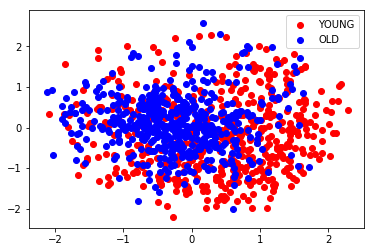

In [42]:
id2index = { v: k for k, v in enumerate(like_df.user_id.cat.categories)}

young = (
    user_df[(user_df.age>0) & (user_df.age<20)]
    .user_id.map(id2index)
    .dropna().astype(int).sample(500))

plt.scatter(x=pca_matrix[young.values, 0],
            y=pca_matrix[young.values, 1],
            c='red',
            label='YOUNG')

old = (
    user_df[(user_df.age>50) & (user_df.age<100)]
    .user_id.map(id2index)
    .dropna().astype(int).sample(500))
plt.scatter(x=pca_matrix[old.values, 0],
            y=pca_matrix[old.values, 1],
            c='blue',
            label='OLD')
plt.legend()
plt.show() 

성별 혹은 연령별로 유저를 분석하여 유저에 대한 이해도를 높이는 것은 좋은 추천시스템을 만드는데 반드시 필요한 작업입니다. 예를 들어 앞서 언급했던 Cold Start 문제를 해결하기 위해 같은 성별 혹은 연령대의 유저군에 속한 유저들이 좋아하는 아티스트를 추천할 수도 있을 것입니다. 또는 마케팅을 수행하는데 활용할 수도 있을 것입니다.


### (3) 유저의 취향과 비슷한 특성을 가진 아티스트 추천하기

앞서 한 아티스트의 임베딩 벡터와 전체 아티스트의 임베딩 행렬을 이용해 아티스트 사이의 유사도를 구하여 유저가 즐겨듣는 아티스트와 유사한 아티스트를 추천해보았습니다. 이번에는 유저 임베딩 벡터와 전체 아티스트의 임베딩 행렬을 이용해 유저와 비슷한 아티스트를 찾아 추천해보겠습니다.

In [43]:
# 유저별 이미 들은 아티스트 리스트 구성하기
artistset_per_user = (
    like_df
    .groupby('user_id')
    ['artist_id']
    .apply(frozenset)
)

**메탈, 락과 같은 음악을 많은 들은 사람**

`user_embedding_df`에서 `target_id = 300`인 유저는 메탈, 락과 같은 음악을 좋아하는 유저입니다. 유저 임베딩 벡터와 아티스트 임베딩 행렬을 가지고 내적 행렬을 수행하면 유저와 아티스트 사이의 유사도를 구할 수 있습니다.

In [44]:
target_id = 300
target_user = user_embedding_df.loc[target_id]
print([artist_id2name[f] for f in artistset_per_user[target_id]])

['angelo badalamenti', 'red hot chili peppers', 'marilyn manson', 'led zeppelin', 'eric clapton', 'metallica', 'iron maiden', 'u2', 't.love', 'slipknot', 'queens of the stone age', "guns n' roses", 'iced earth', 'avril lavigne', 'guano apes', 'the offspring', 'alice in chains', 'in flames', 'pantera', 'john williams', 'daniel licht', 'high and mighty color', 'karmacoma', 'down', 'missile girl scoot', 'akira yamaoka', 'the kilimanjaro darkjazz ensemble', 'mondo generator', 'raging speedhorn', 'graeme revell', 'spiritual beggars', 'as i lay dying', 'frida snell', 'fatboy slim', 'pearl jam', 'isis', 'suicidal tendencies', 'black sabbath', 'stone sour', 'the smashing pumpkins', 'sigur rós', 'godsmack', 'pink', 'no doubt', 'nine inch nails']


target_user와 유사도가 높은 아티스트를 보면 아래와 같이 나옵니다.

In [45]:
(
    artist_embedding_df
    .dot(target_user) # target_user와 유사도 계산하기
    .sort_values(ascending=False)
    [:10]
)

alice in chains     3.930903
koЯn                3.867961
tool                3.782670
maggot brain        3.724733
metallica           3.639945
dave navarro        3.630646
jerry cantrell      3.564366
system of a down    3.555664
godsmack            3.509122
nirvana             3.474177
dtype: float32

**힙합을 많이 들은 사람**

In [46]:
target_id = 1200
target_user = user_embedding_df.loc[target_id]
print([artist_id2name[f] for f in artistset_per_user[target_id]])

['the stone roses', 'snow patrol', 'red hot chili peppers', 'nickelback', 'scouting for girls', 'blur', 'michael jackson', 'michael bublé', 'amy winehouse', 'u2', 'the fratellis', 'bob marley', 'busted', 'jay-z', 'prince', 'kanye west', 'jordin sparks', 'foo fighters', '2pac', 'arctic monkeys', '50 cent', 'coldplay', 'lil wayne', 'the jackson 5', 'shaggy', 'queen', 'the game', 'feeder', 'the streets', 'radiohead', 'jay-z and linkin park', 'rihanna', 'linkin park', 'nina simone', 'blink-182', 'basshunter', 'r. kelly', 'oasis', 'the view', 'usher', 'the verve', 'akon', 'rod stewart', 'stereophonics', 'hard-fi']


In [47]:
(
    artist_embedding_df
    .dot(target_user) # target_user와 유사도 계산하기
    .sort_values(ascending=False)
    [:10]
)

kanye west                       4.343681
oasis                            4.340312
toploader                        4.145401
noel gallagher                   3.925204
coldplay                         3.922978
mark ronson                      3.864729
justin timberlake & timbaland    3.832608
michael jackson                  3.806048
lemar                            3.746588
maroon 5                         3.726501
dtype: float32

**댄스 음악을 좋아하는 사람**

In [48]:
target_id = 209
target_user = user_embedding_df.loc[target_id]
print([artist_id2name[f] for f in artistset_per_user[target_id]])

['gackt', 'christina aguilera', 'beyoncé', 'michael jackson', '安室奈美恵', '12012', '이효리', '新垣結衣', '久石譲', '鄭秀文', 'olivia ong', 'donawhale', '王力宏', 'enrique iglesias', 'alan', 'late night alumni', 'vanessa paradis', 'big bang', 'uverworld', 'abingdon boys school', 'britney spears', 'jennifer lopez', 'timbaland', 'ciara', 'bon jovi', 'avril lavigne', '中島美嘉', '浜崎あゆみ', 'm-flo', 'evanescence', '宇多田ヒカル', 'olivia', '倖田來未', 'spice girls', 'ashlee simpson', 'mariah carey', 'rihanna', 'linkin park', 'nelly furtado', 'madonna', 'enya', 'the pussycat dolls', 'kelly clarkson', 'michelle branch', 'frank sinatra', 'bee gees', 'justin timberlake', 'lady gaga', 'mink', 'boa', 'ガゼット', 'disney']


In [49]:
%%time
(
    artist_embedding_df
    .dot(target_user) # target_user와 유사도 계산하기
    .sort_values(ascending=False)
    [:10]
)

CPU times: user 113 ms, sys: 69.4 ms, total: 182 ms
Wall time: 60.5 ms


utada         4.906682
s.h.e         4.892262
倖田來未          4.805861
sweetbox      4.804545
宇多田ヒカル        4.792812
lisa          4.763324
twins         4.736950
tata young    4.729151
蔡依林           4.686862
boa           4.683221
dtype: float32

# \[ 5. 더 나아가기 \]
---

위와 같이 우리는 고객에 대한 Embedding Vector, 아티스트에 대한 Embedding Vector을 구했습니다. 그리고 이러한 Embedding Vector을 통해 어떻게 고객에게 적절히 추천할 수 있는지에 대해서도 배웠습니다. 그럼 이를 통해 서비스를 한다면, 어떻게 해야 할까요?

![Imgur](https://i.imgur.com/aTkb7jB.png)


우리는 위에서 배운 implicit으로 고객 Embedding Vector와 제품 Embedding Vector을 만들 수 있습니다. 우리는 주기적으로 배치 서버를 통해, 새로운 데이터에 맞게 고객과 제품에 대한 Embedding Vector을 학습시켜주면 됩니다. <br>
그럼 고객에게 추천을 할 때는 어떻게 해야할까요? 위와 같이 Pandas를 이용해, 유사도를 계산할 수 있지만 이럴 경우 우리는 대량의 요청이 들어왔을 때 빠르게 응답하기 어려울 수 있습니다. 고객의 경험을 위해서는 최소 100ms안에 요청을 처리할 수 있어야 합니다. 하지만 Pandas로는 어렵습니다. 이를 위해 Spotify에서는 자체 추천 서비스를 위한 도구인 Annoy를 오픈소스로 공개하였습니다.

## 1. Spotify 팀의 서빙 도구, Annoy

![Imgur](https://i.imgur.com/8YgiaOj.png)

Annoy는 위와 같이 전체 제품 중 고객에게 맞는 제품을 추천하기 위해, Dot 연산을 수행하여 제일 가까운 10개를 찾는 연산을 보다 빠르게 만들기 위한 라이브러리입니다. Annoy는 위와 같이 모든 제품과 Dot 연산을 수행하는 것이 아닌, 가장 가까울 것으로 예상되는 제품만을 추려 Dot 연산을 수행하는 방식으로 설계되어 있습니다. 즉 가까운 제품끼리 미리 클러스터링을 진행 후, 해당 제품끼리에서만 Dot 연산을 수행하여 최소의 연산으로 우리가 필요한 정보를 추출할 수 있도록 합니다.

In [50]:
from annoy import AnnoyIndex

## 1. 준비하기

우선 우리는 학습한 제품의 Embedding Vector을 Annoy에 저장해야 합니다.<br>

In [52]:
tree = AnnoyIndex(61, "dot") # Dot 유사도를 이용하기

for idx, value in enumerate(artist_embedding_df.values):
    tree.add_item(idx, value)

그리고 몇 개의 Tree를 통해 군집화를 할 것인지 설정합니다. <br> 이 때 Tree가 많을수록 좀 더 정확하게 군집화할 수 있고, 적을수록 좀 더 빠르게 연산을 수행할 수 있습니다.

In [53]:
tree.build(20)

True

## 2. Annoy를 통해 유사도 검색하기

**메탈, 락과 같은 음악을 많은 들은 사람**


In [54]:
target_id = 300
target_user = user_embedding_df.loc[target_id]
print([artist_id2name[f] for f in artistset_per_user[target_id]])

['angelo badalamenti', 'red hot chili peppers', 'marilyn manson', 'led zeppelin', 'eric clapton', 'metallica', 'iron maiden', 'u2', 't.love', 'slipknot', 'queens of the stone age', "guns n' roses", 'iced earth', 'avril lavigne', 'guano apes', 'the offspring', 'alice in chains', 'in flames', 'pantera', 'john williams', 'daniel licht', 'high and mighty color', 'karmacoma', 'down', 'missile girl scoot', 'akira yamaoka', 'the kilimanjaro darkjazz ensemble', 'mondo generator', 'raging speedhorn', 'graeme revell', 'spiritual beggars', 'as i lay dying', 'frida snell', 'fatboy slim', 'pearl jam', 'isis', 'suicidal tendencies', 'black sabbath', 'stone sour', 'the smashing pumpkins', 'sigur rós', 'godsmack', 'pink', 'no doubt', 'nine inch nails']


Annoy를 통해 검색하려면 아래와 같이 작성하면 됩니다.

In [57]:
artist_indices = tree.get_nns_by_vector(target_user, 10)
artist_indices

[172, 913, 183, 281, 33152, 19456, 903, 14082, 769, 39177]

Annoy를 통해 검색하게 되면 훨씬 더 빠른 속도 내에 처리할 수 있습니다. <br>
지금은 상대적으로 적은 수의 데이터를 통해 돌려서 대략 50배 정도 밖에 빨라지지 않았지만<br>
데이터가 늘어날수록 Annoy로 처리하는 것이 훨씬 더 유리하게 됩니다.

이 인덱스를 아티스트 이름으로 바꾸면 아래와 같게 됩니다.

In [58]:
artist_embedding_df.index[artist_indices]

Index(['alice in chains', 'koЯn', 'tool', 'metallica', 'dave navarro',
       'jerry cantrell', 'marilyn manson', 'mad season', 'a perfect circle',
       'none'],
      dtype='object')

**힙합을 많이 들은 사람**

In [59]:
target_id = 1200
target_user = user_embedding_df.loc[target_id]
print([artist_id2name[f] for f in artistset_per_user[target_id]])

['the stone roses', 'snow patrol', 'red hot chili peppers', 'nickelback', 'scouting for girls', 'blur', 'michael jackson', 'michael bublé', 'amy winehouse', 'u2', 'the fratellis', 'bob marley', 'busted', 'jay-z', 'prince', 'kanye west', 'jordin sparks', 'foo fighters', '2pac', 'arctic monkeys', '50 cent', 'coldplay', 'lil wayne', 'the jackson 5', 'shaggy', 'queen', 'the game', 'feeder', 'the streets', 'radiohead', 'jay-z and linkin park', 'rihanna', 'linkin park', 'nina simone', 'blink-182', 'basshunter', 'r. kelly', 'oasis', 'the view', 'usher', 'the verve', 'akon', 'rod stewart', 'stereophonics', 'hard-fi']


Annoy를 통해 검색하면 아래와 같습니다.

In [60]:
artist_indices = tree.get_nns_by_vector(target_user, 10)

이 인덱스를 아티스트 이름으로 바꾸면 아래와 같습니다.

In [61]:
artist_embedding_df.index[artist_indices]

Index(['oasis', 'toploader', 'mark ronson', 'orson', 'the coronas',
       'chris lee', 'chris moyles', 'dj greg j', 'paolo nutini', 'hard-fi'],
      dtype='object')

**댄스 음악을 좋아하는 사람**

In [62]:
target_id = 209
target_user = user_embedding_df.loc[target_id]
print([artist_id2name[f] for f in artistset_per_user[target_id]])

['gackt', 'christina aguilera', 'beyoncé', 'michael jackson', '安室奈美恵', '12012', '이효리', '新垣結衣', '久石譲', '鄭秀文', 'olivia ong', 'donawhale', '王力宏', 'enrique iglesias', 'alan', 'late night alumni', 'vanessa paradis', 'big bang', 'uverworld', 'abingdon boys school', 'britney spears', 'jennifer lopez', 'timbaland', 'ciara', 'bon jovi', 'avril lavigne', '中島美嘉', '浜崎あゆみ', 'm-flo', 'evanescence', '宇多田ヒカル', 'olivia', '倖田來未', 'spice girls', 'ashlee simpson', 'mariah carey', 'rihanna', 'linkin park', 'nelly furtado', 'madonna', 'enya', 'the pussycat dolls', 'kelly clarkson', 'michelle branch', 'frank sinatra', 'bee gees', 'justin timberlake', 'lady gaga', 'mink', 'boa', 'ガゼット', 'disney']


Annoy를 통해 검색하면 아래와 같습니다.

In [63]:
artist_indices = tree.get_nns_by_vector(target_user, 10)

이 인덱스를 아티스트 이름으로 바꾸면 아래와 같습니다.

In [64]:
artist_embedding_df.index[artist_indices]

Index(['tata young', 'boa', '蕭亞軒', 'miz', 'lmnt', 'sergey lazarev', 'alexa',
       '코요태', 'chae yeon', 'seeya'],
      dtype='object')

## 3. Annoy와 유사한 다양한 라이브러리들

Annoy와 같이 Embedding Vector의 유사도를 빠르게 계산해주는 라이브러리들이 많이 존재합니다. 이 중 Annoy는 성능은 준수한 수준에, 매우 간단하게 이용할 수 있어 많이 사용되고 있습니다. 현장 상황에 맞게 다양한 알고리즘을 사용해보시는 것을 권해드립니다.

<img src="https://github.com/erikbern/ann-benchmarks/raw/master/results/glove-100-angular.png" width="500">

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2020/01/13


---